In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from collections import Counter
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
# from google.colab import drive

### **Set Constants**

In [3]:
# Constantes
EPOCHS = 100
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 64
BUFFER_SIZE = 350
FINE_TUNE_POINT = 100
LEARNING_RATE = 0.001


In [4]:
# # Montar Google Drive
# drive.mount('/content/drive')



In [5]:
# Directorio del dataset
DATASET_DIR = '../data/arcgis-survey-images-new'

### **Load Image Datasets**

In [6]:
# Cargar conjuntos de datos de entrenamiento y validación
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 3757 files belonging to 5 classes.
Using 3006 files for training.
Found 3757 files belonging to 5 classes.
Using 751 files for validation.


In [7]:

# Obtener nombres de las clases
class_names = train_ds.class_names

# Aumento de datos
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Aplicar aumento de datos al conjunto de entrenamiento
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))


In [8]:
# Crear conjuntos de validación y prueba
validation_ds = validation_ds.shard(num_shards=2, index=0)
test_ds = validation_ds.shard(num_shards=2, index=1)

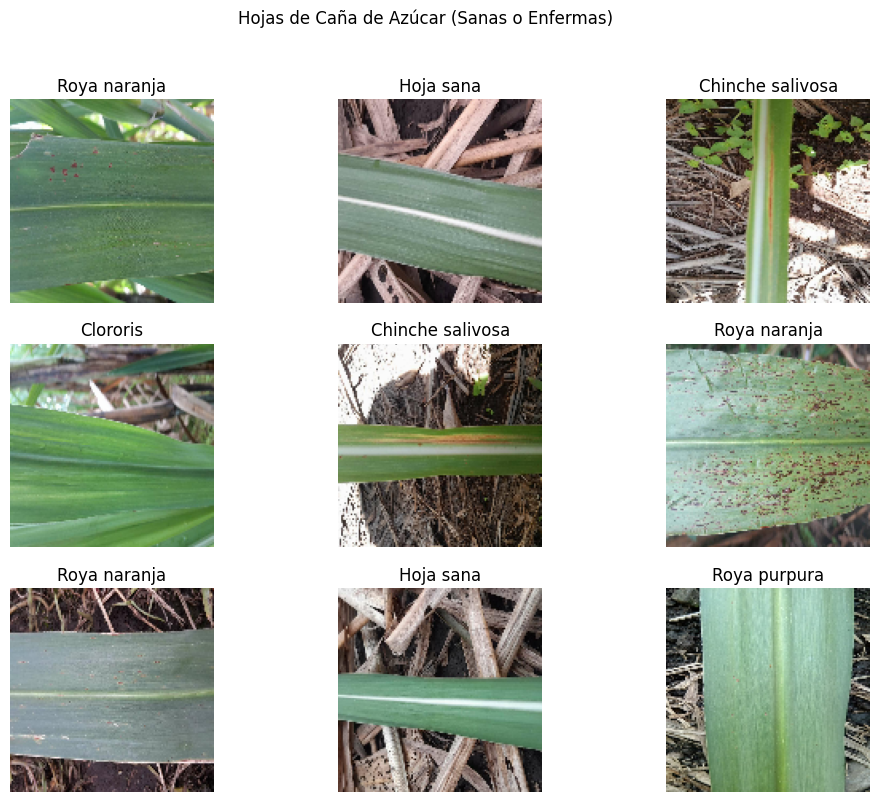

In [9]:
# Mostrar imágenes de ejemplo
plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.suptitle("Hojas de Caña de Azúcar (Sanas o Enfermas)")
        plt.axis("off")

### **Visualize a Set of Training Data**

In [10]:
# Preparar los conjuntos de datos
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# ===============================
# Balanceo de Clases mediante Aumento de Datos
# ===============================

# Paso 1: Obtener las etiquetas del conjunto de entrenamiento
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

# Paso 2: Contar las muestras por clase
class_counts = Counter(train_labels)
print("Cantidad de muestras por clase antes del balanceo:", class_counts)

# Paso 3: Determinar el número objetivo de muestras por clase (la clase más grande)
target_count = max(class_counts.values())
print(f"Objetivo de muestras por clase: {target_count}")

# Paso 4: Separar el conjunto de datos por clases
# Crear un diccionario para almacenar las imágenes por clase
class_datasets = {class_id: [] for class_id in range(len(class_names))}

for images, labels in train_ds.unbatch():
    class_datasets[labels.numpy()].append(images)

# Paso 5: Generar imágenes aumentadas para clases minoritarias
augmented_images = []
augmented_labels = []

for class_id, images in class_datasets.items():
    current_count = len(images)
    if current_count < target_count:
        num_to_augment = target_count - current_count
        print(f"Balanceando clase '{class_names[class_id]}' con {num_to_augment} imágenes aumentadas.")
        for i in range(num_to_augment):
            # Seleccionar una imagen al azar para aumentar
            image = images[np.random.randint(0, current_count)]
            image = tf.expand_dims(image, 0)  # Añadir dimensión de batch
            augmented_image = data_augmentation(image, training=True)
            augmented_image = tf.squeeze(augmented_image, 0)  # Eliminar dimensión de batch
            augmented_images.append(augmented_image)
            augmented_labels.append(class_id)

# Paso 6: Crear un nuevo conjunto de datos con las imágenes aumentadas
if augmented_images:
    augmented_images = tf.stack(augmented_images)
    augmented_labels = tf.constant(augmented_labels)
    augmented_ds = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
    augmented_ds = augmented_ds.batch(BATCH_SIZE)

    # Combinar el conjunto de entrenamiento original con las imágenes aumentadas
    balanced_train_ds = train_ds.concatenate(augmented_ds)
else:
    balanced_train_ds = train_ds

# Paso 7: Preparar el conjunto de datos balanceado
balanced_train_ds = balanced_train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verificar el nuevo conteo de clases
balanced_train_labels = []
for images, labels in balanced_train_ds:
    balanced_train_labels.extend(labels.numpy())

balanced_class_counts = Counter(balanced_train_labels)
print("Cantidad de muestras por clase después del balanceo:", balanced_class_counts)

Cantidad de muestras por clase antes del balanceo: Counter({3: 920, 2: 675, 0: 664, 4: 419, 1: 328})
Objetivo de muestras por clase: 920
Balanceando clase 'Chinche salivosa' con 256 imágenes aumentadas.
Balanceando clase 'Clororis' con 592 imágenes aumentadas.
Balanceando clase 'Hoja sana' con 245 imágenes aumentadas.
Balanceando clase 'Roya purpura' con 501 imágenes aumentadas.
Cantidad de muestras por clase después del balanceo: Counter({0: 920, 3: 920, 2: 920, 1: 920, 4: 920})


### **Load Base Model**

In [12]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB7

# Cargar el modelo base con MobileNetV2
base_model = EfficientNetB7(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

# Congelar capas hasta el punto de ajuste fino
for layer in base_model.layers[:FINE_TUNE_POINT]:
    layer.trainable = False


In [13]:
# Definir el modelo completo con capas adicionales
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,  # Incluir aumento de datos en el modelo
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names))
])

In [14]:
# Compilar el modelo con tasa de aprendizaje fija
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
# Definir callback de Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-5
)

In [17]:
history = model.fit(
    balanced_train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 945s 11s/step - accuracy: 0.2739 - loss: 3.5224 - val_accuracy: 0.3255 - val_loss: 28.7433 - learning_rate: 0.0010
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 835s 12s/step - accuracy: 0.4056 - loss: 2.6028 - val_accuracy: 0.1589 - val_loss: 2.8645 - learning_rate: 0.0010
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 790s 11s/step - accuracy: 0.3810 - loss: 2.2364 - val_accuracy: 0.4531 - val_loss: 1.8407 - learning_rate: 0.0010
Epoch 4/100
33/72 ━━━━━━━━━━━━━━━━━━━━ 7:00 11s/step - accuracy: 0.3539 - loss: 2.0918

KeyboardInterrupt: 

### **Create the Classification Model**

### **Fit the Model**

### **Classification Report**

Text(0.5, 0, 'Epoch')

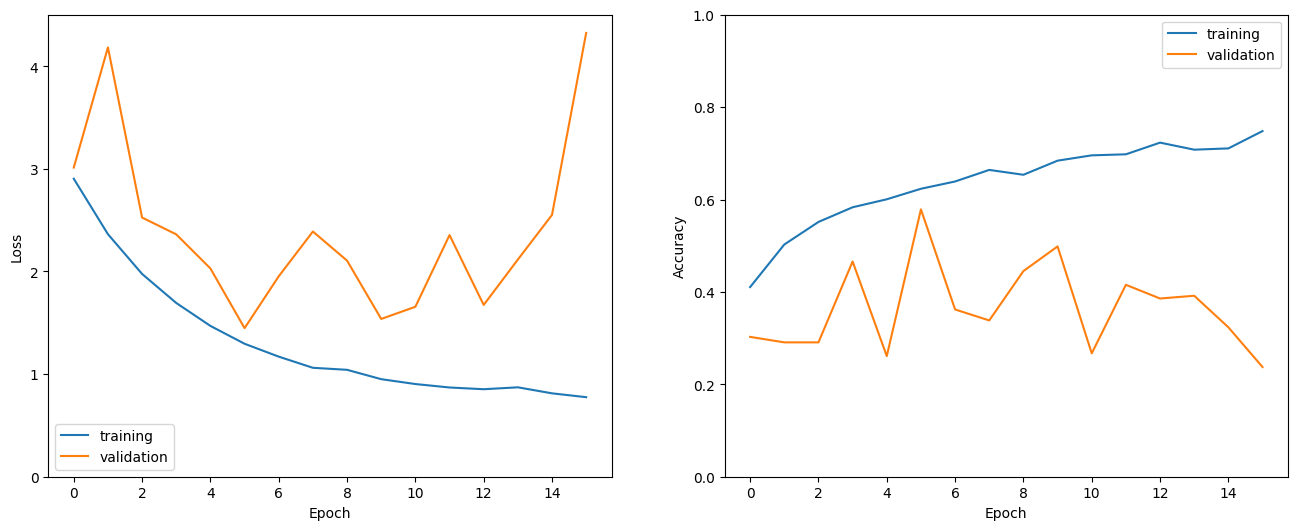

In [ ]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
model.evaluate(test_ds, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 0.6365 - loss: 1.3819


{'accuracy': 0.6206896305084229, 'loss': 1.3845689296722412}

In [ ]:
# # Guardar el modelo completo en formato .keras
# model.save('ruta_donde_guardar_modelo/mi_modelo.keras')

In [ ]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 779ms/step


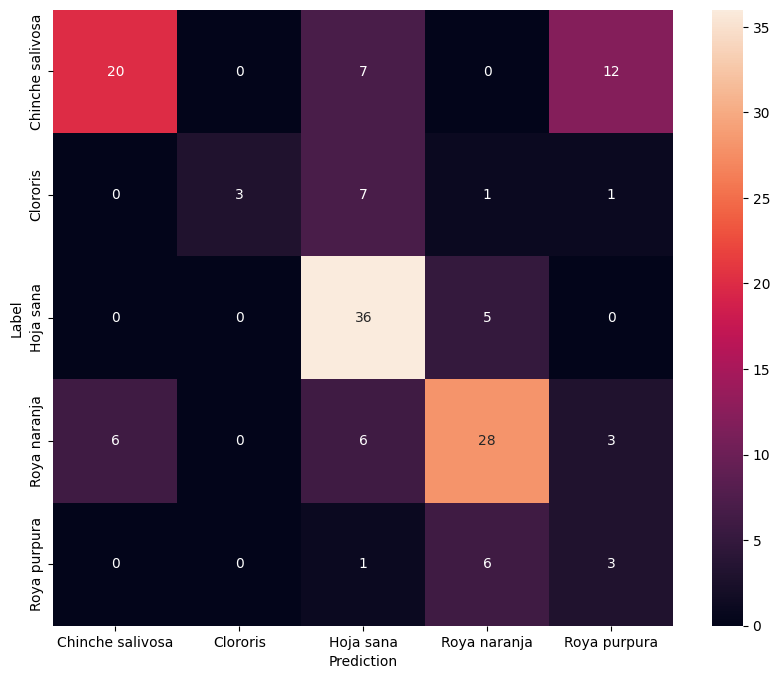

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6365 - loss: 1.3819
Resultados de evaluación en test set:
accuracy: 0.6207
loss: 1.3846
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.77      0.51      0.62        39
        Clororis       1.00      0.25      0.40        12
       Hoja sana       0.63      0.88      0.73        41
    Roya naranja       0.70      0.65      0.67        43
    Roya purpura       0.16      0.30      0.21        10

        accuracy                           0.62       145
       macro avg       0.65      0.52      0.53       145
    weighted avg       0.69      0.62      0.62       145



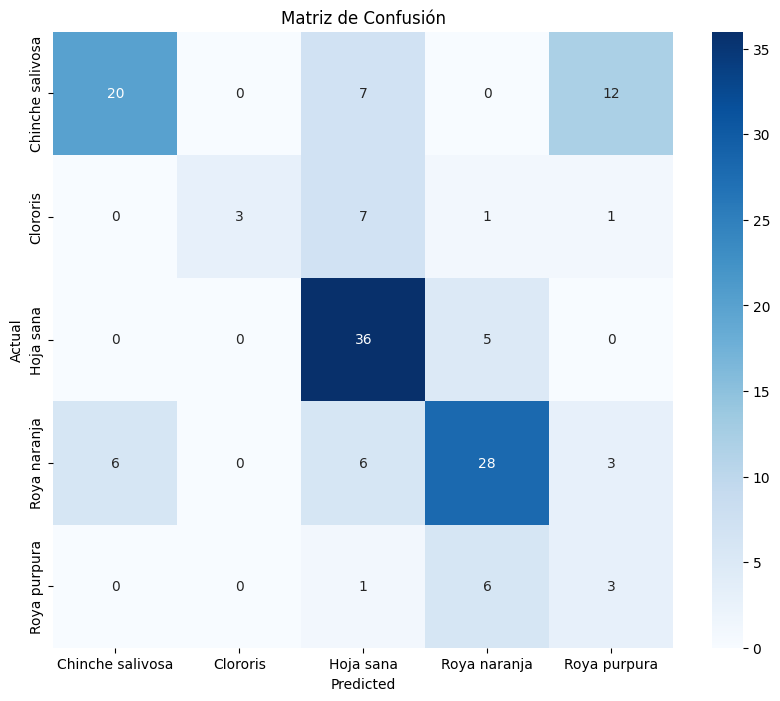

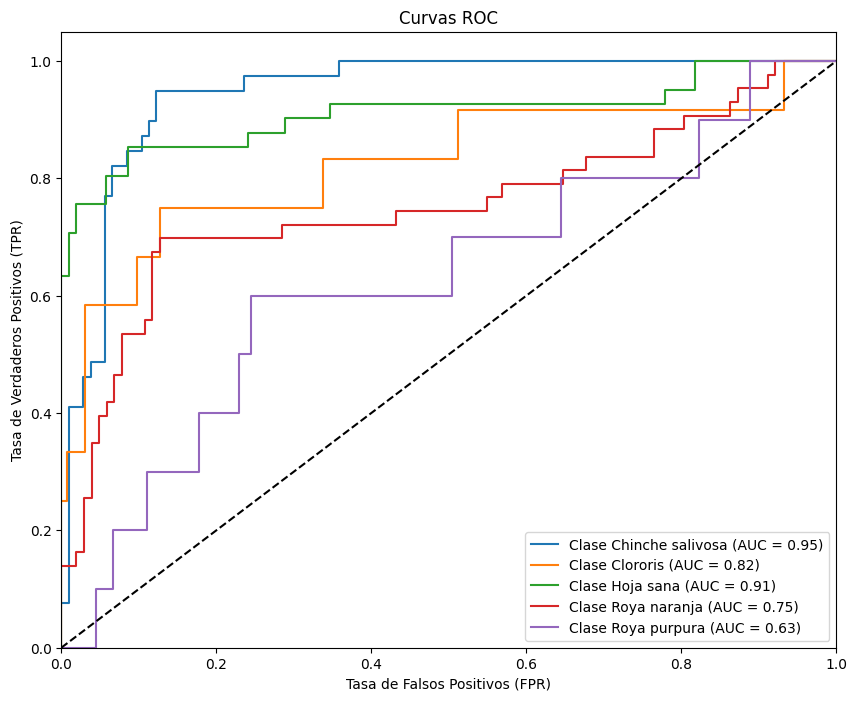

In [ ]:

# Evaluación del modelo y visualización de resultados

# Evaluar el modelo en el conjunto de test
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

# Predicción de etiquetas en el conjunto de test
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Reporte de clasificación
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Matriz de confusión
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curvas ROC y AUC para cada clase
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


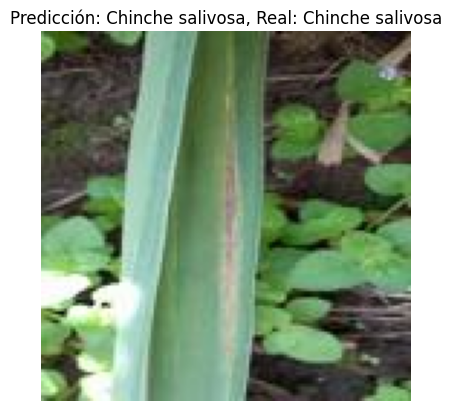

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


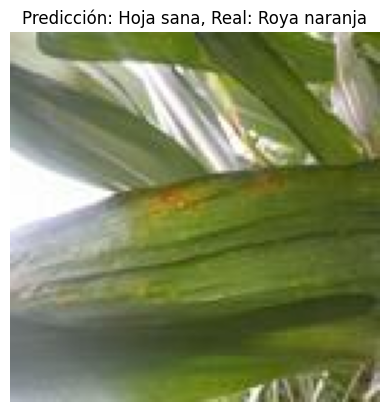

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


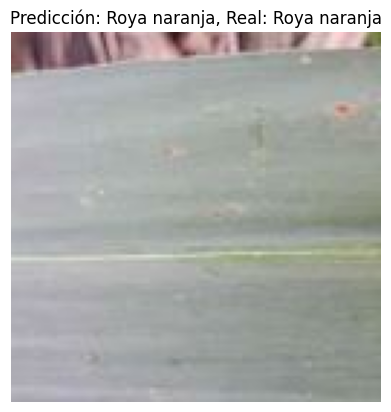

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


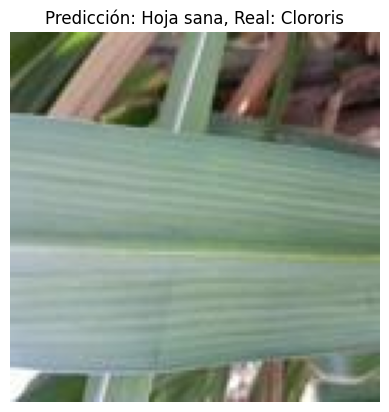

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


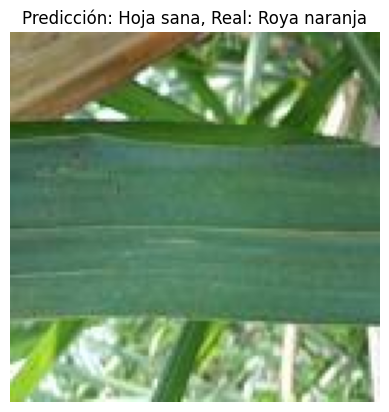

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Función para mostrar predicciones aleatorias
def show_predictions(model, dataset, num_images=5):
    random_indices = np.random.choice(len(list(dataset)), num_images, replace=False)

    for i in random_indices:
        # Extraer la imagen y la etiqueta del conjunto de datos
        image_batch, label_batch = next(iter(dataset.skip(i).take(1)))

        # Predecir utilizando el modelo
        predictions = model.predict(image_batch)
        predicted_class = np.argmax(predictions, axis=1)[0]
        true_class = label_batch[0].numpy()

        # Mostrar la imagen y las predicciones
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(f"Predicción: {class_names[predicted_class]}, Real: {class_names[true_class]}")
        plt.axis('off')
        plt.show()

# Mostrar 5 predicciones aleatorias
show_predictions(model, validation_ds, num_images=5)


In [ ]:
# Guardar el modelo en formato .keras
model.save("keras_plague_classifier.keras")
print("Modelo guardado en 'keras_plague_classifier1.keras'.")

Modelo guardado en 'keras_plague_classifier1.keras'.


In [ ]:
loaded_model = load_model("keras_plague_classifier.keras")
loaded_model.summary()  # Esto te dará una visión detallada del modelo


NameError: name 'load_model' is not defined

In [ ]:
# Evaluar el modelo cargado para verificar
test_loss, test_acc = loaded_model.evaluate(test_ds)
print(f"Métricas de evaluación del modelo cargado: Pérdida = {test_loss}, Precisión = {test_acc}")